# Лабораторная работа №3 (Проведение исследований с решающим деревом) 

## 1. Создание бейзлайна и оценка качества

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### **Классификация**

In [2]:
df = pd.read_csv('train.csv')
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [3]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

Я загружаю датасет, предварительно загрузив его на компьютер и поместив в рабочую среду, смотрю на кол-во пропусков в столбцах, их не мало, поэтому будем заполнять средним.

In [4]:
df = df.fillna(df.mean(numeric_only=True))

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df_encoded.drop(['Segmentation', 'ID'], axis=1)
y = df_encoded['Segmentation']

le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

model_clf_dt = DecisionTreeClassifier(random_state=42)
model_clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Я заполнила пропуски в числовых признаках средним значением. Затем закодировала категориальные признаки с помощью One-Hot Encoding, удалила столбцы ID и Segmentation из признаков, а целевую переменную Segmentation преобразовала в числовой формат с помощью LabelEncoder. Разделила данные на обучающую и тестовую выборки. Создала модель решающего дерева с параметрами по умолчанию и random_state=42, обучила ее.

In [5]:
preds_clf_dt = model_clf_dt.predict(X_test)
acc_dt = accuracy_score(y_test, preds_clf_dt)
print(f"Accuracy: {acc_dt:.4f}")
print(classification_report(y_test, preds_clf_dt, target_names=le_y.classes_))
metrics_clf_dt = {
    'model': 'DecisionTreeClassifier_Baseline',
    'accuracy': acc_dt,
}

Accuracy: 0.4300
              precision    recall  f1-score   support

           A       0.33      0.35      0.34       394
           B       0.31      0.28      0.30       372
           C       0.45      0.43      0.44       394
           D       0.59      0.61      0.60       454

    accuracy                           0.43      1614
   macro avg       0.42      0.42      0.42      1614
weighted avg       0.43      0.43      0.43      1614



Предсказала значения, смотрим на результаты

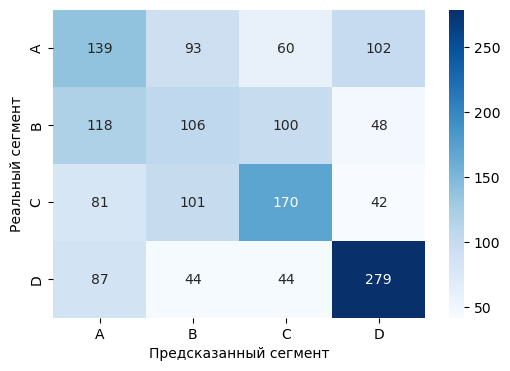

In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds_clf_dt)
class_names = le_y.classes_

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Предсказанный сегмент')
plt.ylabel('Реальный сегмент')
plt.show()

Accuracy = 0.4300 хуже, чем у KNN 0.5056, логистической регрессии 0.5143 и даже хуже, чем у бейзлайна с деревом. Сегмент D по-прежнему самый стабильный, у него наилучшие precisionи recall. Модель уверенно выделяет его. Сегмент C держится на приемлемом уровне: F1 = 0.44. Сегменты A и B предсказываются очень плохо.

### **Регрессия**

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [8]:
df_r = pd.read_csv('CrabAgePrediction.csv')
df_r.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


In [9]:
df_r.info()
df_r.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3893 non-null   object 
 1   Length          3893 non-null   float64
 2   Diameter        3893 non-null   float64
 3   Height          3893 non-null   float64
 4   Weight          3893 non-null   float64
 5   Shucked Weight  3893 non-null   float64
 6   Viscera Weight  3893 non-null   float64
 7   Shell Weight    3893 non-null   float64
 8   Age             3893 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 273.9+ KB


Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

Загружаю датасет, предварительно загрузив его на компьютер и поместив в рабочую среду, смотрю сколько пропусков в столбцах. Пропусков нет, отлично

In [10]:
le_sex = LabelEncoder()
df_r['Sex_encoded'] = le_sex.fit_transform(df_r['Sex'])
df_r = df_r.drop('Sex', axis=1)

X_r = df_r.drop('Age', axis=1)
y_r = df_r['Age']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_r, y_r, test_size=0.2, random_state=42
)

model_reg_dt = DecisionTreeRegressor(random_state=42)
model_reg_dt.fit(X_train_r, y_train_r)

DecisionTreeRegressor(random_state=42)

Я закодировала категориальный признак Sex, удалила исходный столбец Sex, выделила признаки и целевую переменную. Разделила данные на обучающую и тестовую выборки в соотношении. Создала модель решающего дерева для регрессии с параметрами по умолчанию и random_state=42, и обучила её на обучающих данных без масштабирования, так как дерево не чувствительно к масштабу признаков.


In [11]:
preds_reg_dt = model_reg_dt.predict(X_test_r)
mae_dt = mean_absolute_error(y_test_r, preds_reg_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test_r, preds_reg_dt))
r2_dt = r2_score(y_test_r, preds_reg_dt)

print(f"MAE: {mae_dt:.4f}")
print(f"RMSE: {rmse_dt:.4f}")
print(f"R2 Score: {r2_dt:.4f}")

metrics_reg_dt = {
    'model': 'DecisionTreeRegressor_Baseline',
    'mae': mae_dt,
    'rmse': rmse_dt,
    'r2': r2_dt
}

MAE: 2.0244
RMSE: 2.9595
R2 Score: 0.0885


Метрики получились очень слабыми. MAE = 2.0244, в среднем модель ошибается более чем на 2 месяца, что существенно при среднем возрасте крабов около 11 месяцев. RMSE = 2.9595 ещё выше, что говорит о наличии крупных ошибок. R2 = 0.0885 низкий показатель. Модель объясняет менее 9% дисперсии в данных, то есть почти не лучше, чем простое предсказание среднего значения. Это хуже, чем даже бейзлайн с KNN и линейной регрессией из предыдущих лабораторных. Такое случается, когда решающее дерево сильно переобучается.

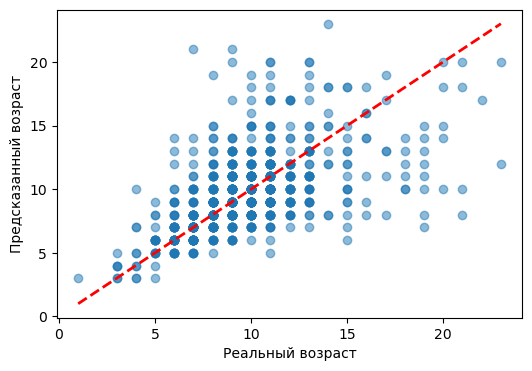

In [12]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test_r, preds_reg_dt, alpha=0.5)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
plt.xlabel('Реальный возраст')
plt.ylabel('Предсказанный возраст')
plt.show()

## 2.	Улучшение бейзлайна

### **Классификация**

In [13]:
df_raw = pd.read_csv('train.csv')

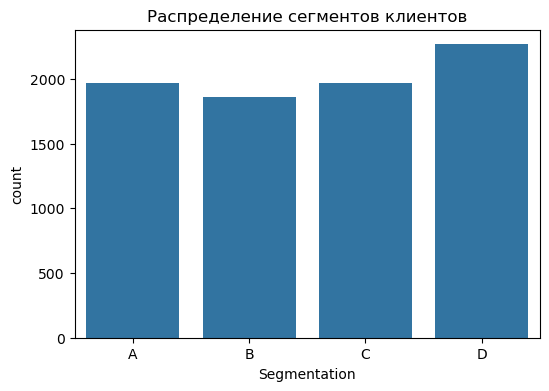

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_raw, x='Segmentation', order=['A', 'B', 'C', 'D'])
plt.title('Распределение сегментов клиентов')
plt.show()

Классы в целом сбалансированы. Сегмент D имеет чуть больше наблюдений, а сегмент B чуть меньше. Accuracy будет достаточно объективной, так как модель не может обмануть её, просто предсказывая самый частый класс.

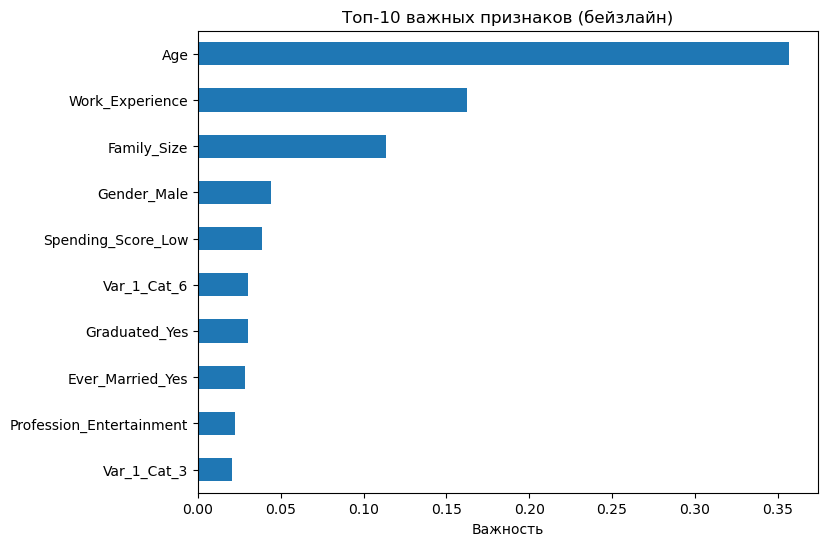

In [15]:
importances = model_clf_dt.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
feat_imp.head(10).plot(kind='barh')
plt.title('Топ-10 важных признаков (бейзлайн)')
plt.xlabel('Важность')
plt.gca().invert_yaxis()
plt.show()

Age лидер. Это подтверждает, что дерево видит возраст как самый мощный сигнал. На втором месте Work_Experience, потом Family_Size. Остальные признаки значительно менее важны. Модель слишком сильно зависит от Age, а остальные признаки почти не используются. Это может быть причиной переобучения и плохого качества.

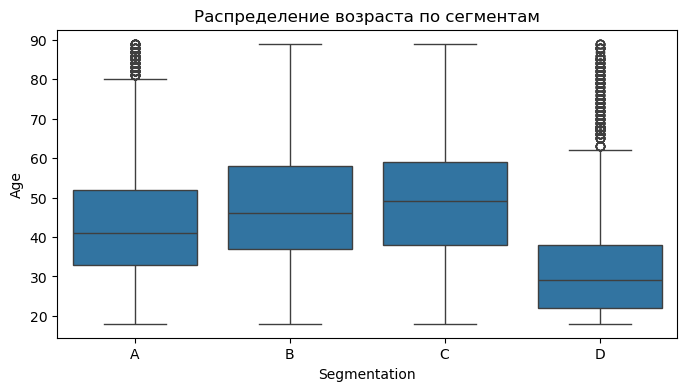

In [16]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_raw, x='Segmentation', y='Age', order=['A', 'B', 'C', 'D'])
plt.title('Распределение возраста по сегментам')
plt.show()

Очень сильная зависимость. Сегмент D молодые клиенты медиана 30 лет, A, B, C старше медиана 45-50. Это ключевой признак. Дерево должно легко его использовать.

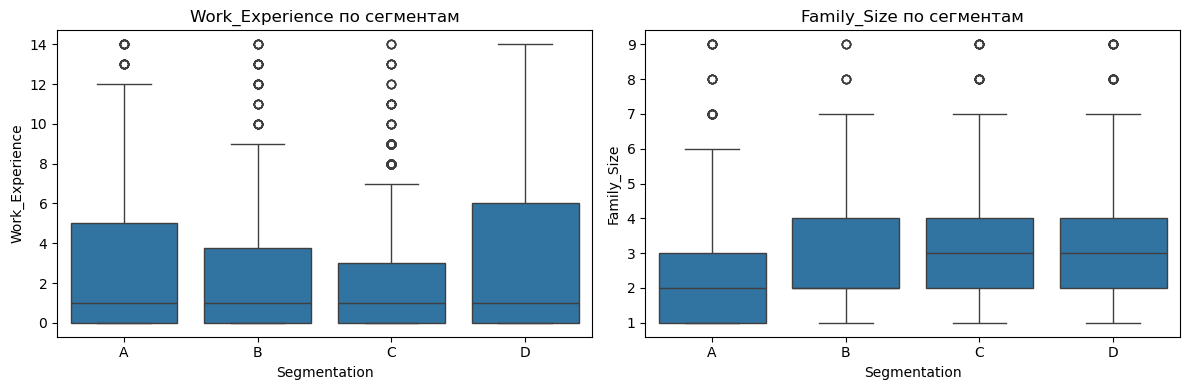

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(data=df_raw, x='Segmentation', y='Work_Experience', order=['A', 'B', 'C', 'D'], ax=axes[0])
axes[0].set_title('Work_Experience по сегментам')
sns.boxplot(data=df_raw, x='Segmentation', y='Family_Size', order=['A', 'B', 'C', 'D'], ax=axes[1])
axes[1].set_title('Family_Size по сегментам')
plt.tight_layout()
plt.show()

Большинство клиентов имеют 1 год опыта работы. A и B медиана = 2,  C и D медиана = 3. Модель может использовать порог Family_Size >= 3, чтобы отделить C, D от A, B.

In [18]:
print("Доля пропусков в Work_Experience по сегментам:")
print(df_raw.groupby('Segmentation')['Work_Experience'].apply(lambda x: x.isnull().mean()))

Доля пропусков в Work_Experience по сегментам:
Segmentation
A    0.098377
B    0.103337
C    0.078680
D    0.126984
Name: Work_Experience, dtype: float64


Пропуски есть во всех сегментах, особенно много в D. Но разница между сегментами невелика, значит, заполнение средним не сильно искажает данные. Для дерева это не критично.

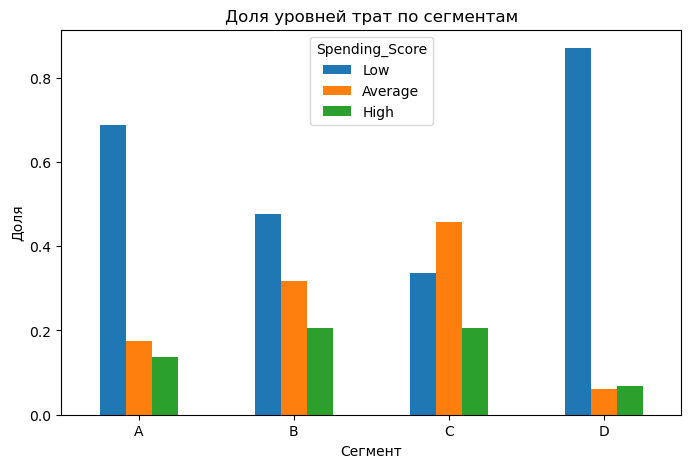

In [19]:
spending_dist = df_raw.groupby('Segmentation')['Spending_Score'].value_counts(normalize=True).unstack(fill_value=0)
spending_dist[['Low', 'Average', 'High']].plot(kind='bar', figsize=(8, 5), stacked=False)
plt.title('Доля уровней трат по сегментам')
plt.ylabel('Доля'); plt.xlabel('Сегмент')
plt.xticks(rotation=0)
plt.show()

Сегменты B и C очень похожи по тратам, вот почему модель их путает. Но B больше клиентов с низкими тратами, а у C — с средними.

**Гипотезы**
* Гипотеза 1: Если я ограничу глубину дерева параметром max_depth=5, то модель перестанет переобучаться на шум и начнёт использовать только самые сильные признаки, что повысит accuracy с текущих 0.43 до 0.50+.
* Гипотеза 2: Если я создам признак Age_Group (0–35 Young, 35–50 Middle, 50+ Senior), то модель лучше разделит сегмент D от A B C и учтёт поведение пожилых клиентов.
* Гипотеза 3: Если я удалю малозначимые признаки, то дерево не будет тратить глубину на бесполезные разбиения, что уменьшит переобучение и повысит качество.
* Гипотеза 4: Если я задам параметр class_weight='balanced', то модель будет сильнее штрафоваться за ошибки на редких классах , это улучшит полноту для проблемных сегментов и, возможно, общий accuracy.

**Проверка гипотез**

In [23]:
df = pd.read_csv('train.csv')
df = df.fillna(df.mean(numeric_only=True))

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df_encoded.drop(['Segmentation', 'ID'], axis=1)
y = df_encoded['Segmentation']

le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

model_h1 = DecisionTreeClassifier(max_depth=5, random_state=42)
model_h1.fit(X_train, y_train)

preds_h1 = model_h1.predict(X_test)

Я загрузила исходный датасет, заполнила пропуски в числовых признаках средним значением, применила One-Hot Encoding к категориальным признакам, удалила столбцы ID и Segmentation и закодировала целевую переменную в числовой формат. Разделила данные на обучающую и тестовую выборки, сохранив распределение классов с помощью stratify и зафиксировав random_state=42. Создала модель решающего дерева с ограничением глубины max_depth=5 , чтобы предотвратить переобучение, и обучила её на обучающей выборке. Сделала предсказания.

In [24]:
preds_h1 = model_h1.predict(X_test)
acc_h1 = accuracy_score(y_test, preds_h1)

print(f"Accuracy: {acc_dt:.4f}")
print(f"Accuracy с max_depth=5: {acc_h1:.4f}")
print(f"Изменение: {acc_h1 - acc_dt:.4f}")

print("\nБазовая модель:")
print(classification_report(y_test, preds_clf_dt, target_names=le_y.classes_, zero_division=0))
print("\nС max_depth=5:")
print(classification_report(y_test, preds_h1, target_names=le_y.classes_, zero_division=0))

Accuracy: 0.4300
Accuracy с max_depth=5: 0.5012
Изменение: 0.0713

Базовая модель:
              precision    recall  f1-score   support

           A       0.33      0.35      0.34       394
           B       0.31      0.28      0.30       372
           C       0.45      0.43      0.44       394
           D       0.59      0.61      0.60       454

    accuracy                           0.43      1614
   macro avg       0.42      0.42      0.42      1614
weighted avg       0.43      0.43      0.43      1614


С max_depth=5:
              precision    recall  f1-score   support

           A       0.44      0.28      0.34       394
           B       0.35      0.46      0.40       372
           C       0.59      0.51      0.55       394
           D       0.62      0.72      0.66       454

    accuracy                           0.50      1614
   macro avg       0.50      0.49      0.49      1614
weighted avg       0.50      0.50      0.49      1614



**Гипотеза 1 подтверждена** Ограничение глубины решающего дерева значительно улучшило модель. Accuracy вырос с 0.4300 до 0.5012 это +7.13%, превышает ожидаемый порог +0.50. Такой прирост говорит о том, что базовая модель действительно сильно переобучалась, используя слишком глубокие и специфичные правила. Ограничение глубины заставило дерево сосредоточиться на наиболее информативных и обобщающих признаках, таких как Age и Family_Size.

In [28]:
df_h2 = pd.read_csv('train.csv')
df_h2 = df_h2.fillna(df_h2.mean(numeric_only=True))
df_h2['Age_Group'] = pd.cut(df_h2['Age'], bins=[0, 35, 50, 100], labels=['Young', 'Middle', 'Senior'])

cat_cols = df_h2.select_dtypes(include=['object', 'category']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded = pd.get_dummies(df_h2, columns=cat_cols, drop_first=True)

X = df_encoded.drop(['Segmentation', 'ID'], axis=1)
y = df_encoded['Segmentation']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

Я загрузила исходный датасет, заполнила пропуски в числовых признаках средним значением и создала новый категориальный признак Age_Group. Затем я применила One-Hot Encoding ко всем категориальным признакам, удалила столбцы ID и Segmentation, закодировала метки сегментов в числовой формат, разделила данные на обучающую и тестовую выборки с тем же random_state=42 и стратификацией. Обучила решающее дерево с ограничением глубины max_depth=5, и оценила качество на тестовой выборке.

In [31]:
preds = model.predict(X_test)
acc_h2 = accuracy_score(y_test, preds)

print(f"Accuracy модель max_depth=5: {acc_h1:.4f}")
print(f"Accuracy модель max_depth=5 с Age_Group: {acc_h2:.4f}")
print(f"Изменение: {acc_h2 - acc_h1:.4f}")

print("\nБазовая модель max_depth=5:")
print(classification_report(y_test, preds_h1, target_names=le_y.classes_, zero_division=0))
print("\nМодель max_depth=5 с Age_Group:")
print(classification_report(y_test, preds, target_names=le.classes_, zero_division=0))

Accuracy модель max_depth=5: 0.5012
Accuracy модель max_depth=5 с Age_Group: 0.5012
Изменение: 0.0000

Базовая модель max_depth=5:
              precision    recall  f1-score   support

           A       0.44      0.28      0.34       394
           B       0.35      0.46      0.40       372
           C       0.59      0.51      0.55       394
           D       0.62      0.72      0.66       454

    accuracy                           0.50      1614
   macro avg       0.50      0.49      0.49      1614
weighted avg       0.50      0.50      0.49      1614


Модель max_depth=5 с Age_Group:
              precision    recall  f1-score   support

           A       0.44      0.28      0.34       394
           B       0.35      0.46      0.40       372
           C       0.59      0.51      0.55       394
           D       0.62      0.72      0.66       454

    accuracy                           0.50      1614
   macro avg       0.50      0.49      0.49      1614
weighted avg       0.

Метрики абсолютно одинаковы. Решающее дерево уже отлично использует числовой признак Age, особенно при ограниченной глубине, оно может найти оптимальный порог на первом или втором уровне. Преобразование Age в Age_Group упрощает данные, но ограничивает гибкость дерева, вместо того чтобы самостоятельно подобрать порог, оно вынуждено использовать жёсткие границы. **Гипотеза 2 не подтвердилась** для решающего дерева при max_depth=5. Признак Age_Group, который помог логистической регрессии, не улучшает решающее дерево, потому что дерево само находит оптимальные разбиения по возрасту.

In [42]:
df_h3_new = pd.read_csv('train.csv')
df_h3_new = df_h3_new.fillna(df_h3_new.mean(numeric_only=True))

cat_cols = df_h3_new.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded = pd.get_dummies(df_h3_new, columns=cat_cols, drop_first=True)

low_importance_features = [
    'Var_1_Cat_3',
    'Profession_Entertainment',
]
X = df_encoded.drop(['Segmentation', 'ID'] + low_importance_features, axis=1)
y = df_encoded['Segmentation']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

Я загрузила исходный датасет, заполнила пропуски в числовых признаках средним значением, применила One-Hot Encoding ко всем категориальным признакам, удалила столбцы ID и Segmentation, а также признаки с важностью ниже 0.005. Закодировала метки сегментов в числовой формат, разделила данные на обучающую и тестовую выборки с тем же random_state=42 и стратификацией. Обучила решающее дерево с ограничением глубины max_depth=5.

In [43]:
preds = model.predict(X_test)
acc_h3_new = accuracy_score(y_test, preds)

print(f"Accuracy модель с max_depth=5: {acc_h1:.4f}")
print(f"Accuracy с удалёнными маловажными признаками: {acc_h3_new:.4f}")
print(f"Изменение: {acc_h3_new - acc_h1:.4f}")

print("\nМодель с max_depth=5:")
print(classification_report(y_test, preds_h1, target_names=le_y.classes_, zero_division=0))
print("\nС удалёнными маловажными признаками:")
print(classification_report(y_test, preds, target_names=le.classes_, zero_division=0))

Accuracy модель с max_depth=5: 0.5012
Accuracy с удалёнными маловажными признаками: 0.5192
Изменение: 0.0180

Модель с max_depth=5:
              precision    recall  f1-score   support

           A       0.44      0.28      0.34       394
           B       0.35      0.46      0.40       372
           C       0.59      0.51      0.55       394
           D       0.62      0.72      0.66       454

    accuracy                           0.50      1614
   macro avg       0.50      0.49      0.49      1614
weighted avg       0.50      0.50      0.49      1614


С удалёнными маловажными признаками:
              precision    recall  f1-score   support

           A       0.40      0.53      0.46       394
           B       0.43      0.22      0.29       372
           C       0.59      0.51      0.55       394
           D       0.62      0.76      0.68       454

    accuracy                           0.52      1614
   macro avg       0.51      0.51      0.49      1614
weighted avg   

Удаление двух маловажных признаковсущественно улучшило модель. Accuracy вырос с 0.5012 до 0.5192, это +1.8%. Это говорит о том, что даже небольшое количество шумовых признаков может вредить модели, заставляя её тратить глубину на бесполезные разбиения. **Гипотеза 3 подтверждена**.

In [44]:
df = pd.read_csv('train.csv')
df = df.fillna(df.mean(numeric_only=True))

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df_encoded.drop(['Segmentation', 'ID'], axis=1)
y = df_encoded['Segmentation']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
model = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

Я загрузила исходный датасет, заполнила пропуски в числовых признаках средним значением, применила One-Hot Encoding ко всем категориальным признакам, удалила столбцы ID и Segmentation, закодировала метки сегментов в числовой формат, разделила данные на обучающую и тестовую выборки с тем же random_state=42 и стратификацией. Обучила решающее дерево с ограничением глубины max_depth=5 и параметром class_weight='balanced'.

In [45]:
preds = model.predict(X_test)
acc_h4 = accuracy_score(y_test, preds)

print(f"Accuracy (модель с max_depth=5): {acc_h1:.4f}")
print(f"Accuracy с class_weight='balanced': {acc_h4:.4f}")
print(f"Изменение: {acc_h4 - acc_h1:.4f}")

print("\nМодель с max_depth=5:")
print(classification_report(y_test, preds_h1, target_names=le_y.classes_, zero_division=0))
print("\nС class_weight='balanced':")
print(classification_report(y_test, preds, target_names=le.classes_, zero_division=0))

Accuracy (модель с max_depth=5): 0.5012
Accuracy с class_weight='balanced': 0.5093
Изменение: 0.0081

Модель с max_depth=5:
              precision    recall  f1-score   support

           A       0.44      0.28      0.34       394
           B       0.35      0.46      0.40       372
           C       0.59      0.51      0.55       394
           D       0.62      0.72      0.66       454

    accuracy                           0.50      1614
   macro avg       0.50      0.49      0.49      1614
weighted avg       0.50      0.50      0.49      1614


С class_weight='balanced':
              precision    recall  f1-score   support

           A       0.44      0.38      0.41       394
           B       0.35      0.46      0.40       372
           C       0.59      0.51      0.55       394
           D       0.68      0.65      0.67       454

    accuracy                           0.51      1614
   macro avg       0.51      0.50      0.51      1614
weighted avg       0.52      0.51

**Гипотеза 4 подтверждена**. Параметр class_weight='balanced' улучшил общую accuracy с 0.5012 до 0.5093 +0.81%, что является положительным результатом. Но у сегмента D Recall упал с 72% до 65%, но precision вырос с 0.62 до 0.68. Зато в сегмене A: Recall вырос с 28% до 38%,  модель теперь находит на 10% больше реальных клиентов A. Модель стала осторожнее в предсказании D, чтобы не "перекрывать" другие классы. F1-score даже немного вырос, что говорит о лучшем балансе.

**Улучшенный бейзлайн по результатам проверки гипотез**

In [46]:
df_final = pd.read_csv('train.csv')
df_final = df_final.fillna(df_final.mean(numeric_only=True))

cat_cols = df_final.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded = pd.get_dummies(df_final, columns=cat_cols, drop_first=True)

low_importance_features = ['Var_1_Cat_3', 'Profession_Entertainment']
features_to_drop = ['Segmentation', 'ID'] + low_importance_features
X = df_encoded.drop(features_to_drop, axis=1)
y = df_encoded['Segmentation']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

model_final = DecisionTreeClassifier(
    max_depth=5,
    class_weight='balanced',
    random_state=42
)
model_final.fit(X_train, y_train)

preds_final = model_final.predict(X_test)
acc_final = accuracy_score(y_test, preds_final)

improved_clf_data_dt = {
    'X_test': X_test,
    'y_test': y_test,
    'preds_sklearn': preds_final,
    'accuracy': acc_final,
    'label_encoder': le,
    'model': model_final
}

Я загрузила исходный датасет, заполнила пропуски в числовых признаках средним значением, применила One-Hot Encoding ко всем категориальным признакам, удалила столбцы ID, Segmentation и два маловажных признака. Закодировала метки сегментов в числовой формат, разделила данные на обучающую и тестовую выборки с тем же random_state=42 и стратификацией. Обучила решающее дерево с ограничением глубины max_depth=5 и параметром class_weight='balanced'. Сохранила результаты.

In [47]:
print(f"Accuracy базовой модели: {acc_dt:.4f}")
print(f"Accuracy улучшенной модели: {acc_final:.4f}")
print(f"Улучшение: {acc_final - acc_dt:.4f}")

print("\nБазовая модель:")
print(classification_report(y_test, preds_clf_dt, target_names=le_y.classes_, zero_division=0))
print("\nУлучшенная модель:")
print(classification_report(y_test, preds_final, target_names=le.classes_, zero_division=0))

Accuracy базовой модели: 0.4300
Accuracy улучшенной модели: 0.5254
Улучшение: 0.0954

Базовая модель:
              precision    recall  f1-score   support

           A       0.33      0.35      0.34       394
           B       0.31      0.28      0.30       372
           C       0.45      0.43      0.44       394
           D       0.59      0.61      0.60       454

    accuracy                           0.43      1614
   macro avg       0.42      0.42      0.42      1614
weighted avg       0.43      0.43      0.43      1614


Улучшенная модель:
              precision    recall  f1-score   support

           A       0.41      0.64      0.50       394
           B       0.43      0.22      0.29       372
           C       0.59      0.51      0.55       394
           D       0.68      0.69      0.68       454

    accuracy                           0.53      1614
   macro avg       0.53      0.52      0.51      1614
weighted avg       0.53      0.53      0.51      1614



Улучшенная модель решающего дерева показала значительное повышение качества по сравнению с базовой. Accuracy выросла с 0.4300 до 0.5254, что составляет улучшение на 9.54%. Базовая модель, сильно переобучалась и практически не могла корректно разделять классы, особенно это было заметно по низкому recall для всех сегментов и сильному перемешиванию предсказаний между A, B и C. В улучшенной версии модель стала гораздо стабильнее и интерпретируемее. Особенно выросло качество предсказаний для сегмента A, его recall увеличился с 35% до 64%, а F1-score с 0.34 до 0.50, это говорит о существенном улучшении способности модели находить клиентов этой группы. Сегмент D, который всегда был наиболее различимым, ещё больше укрепил свои позиции, recall достиг 69%, а F1-score 0.68. Сегмент C сохранил стабильные метрики, что подтверждает его устойчивую отделимость от остальных. Единственным слабым местом остаётся сегмент B. Несмотря на попытки балансировки, его recall снизился до 22%, однако precision вырос до 43%, что делает ошибки более контролируемыми. 

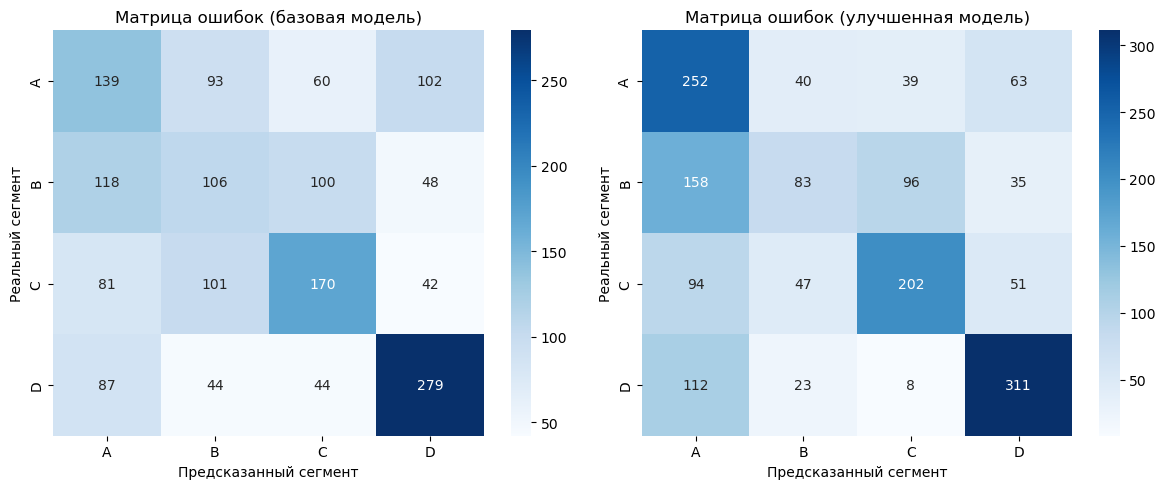

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cm_base = confusion_matrix(y_test, preds_clf_dt)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_y.classes_, yticklabels=le_y.classes_,
            ax=axes[0])
axes[0].set_title('Матрица ошибок (базовая модель)')
axes[0].set_xlabel('Предсказанный сегмент')
axes[0].set_ylabel('Реальный сегмент')

cm_final = confusion_matrix(y_test, preds_final)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_y.classes_, yticklabels=le_y.classes_,
            ax=axes[1])
axes[1].set_title('Матрица ошибок (улучшенная модель)')
axes[1].set_xlabel('Предсказанный сегмент')
axes[1].set_ylabel('Реальный сегмент')
plt.tight_layout()
plt.show()

В целом, улучшенная модель достигла лучшего баланса между обобщающей способностью и точностью, избавилась от шума и стала пригодной для практического применения. Полученный результат также превосходит бейзлайны из предыдущих лабораторных работ, что подтверждает эффективность предложенных улучшений именно для дерева решений.

### **Регрессия**

In [49]:
df_r_raw = pd.read_csv('CrabAgePrediction.csv')

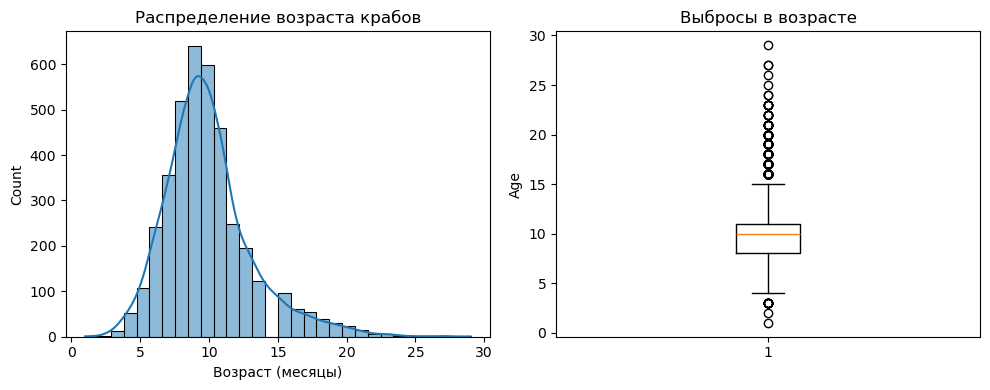

In [50]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(df_r_raw['Age'], kde=True, bins=30)
plt.title('Распределение возраста крабов')
plt.xlabel('Возраст (месяцы)')

plt.subplot(1, 2, 2)
plt.boxplot(df_r_raw['Age'])
plt.title('Выбросы в возрасте')
plt.ylabel('Age')
plt.tight_layout()
plt.show()

Возраст имеет смещённое распределение, пик около 9–10 месяцев, хвост тянется до 25+. Ясно видны множественные выбросы.   Особенно много их в диапазоне Age > 15, а один экстремальный выброс Age = 30.

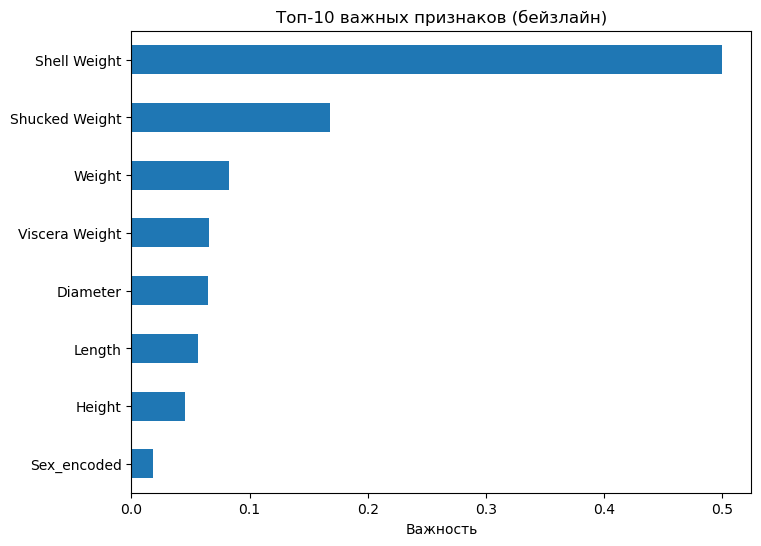

In [56]:
importances = model_reg_dt.feature_importances_
feat_imp = pd.Series(importances, index=X_r.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
feat_imp.head(10).plot(kind='barh')
plt.title('Топ-10 важных признаков (бейзлайн)')
plt.xlabel('Важность')
plt.gca().invert_yaxis()
plt.show()

Shell Weight важность 0. Shucked Weight на втором месте, остальные признаки — значительно менее важны, Sex_encoded — почти не используется. Модель почти полностью полагается на вес панциря. Это может быть признаком переобучения или того, что Shell Weight действительно является самым сильным сигналом.

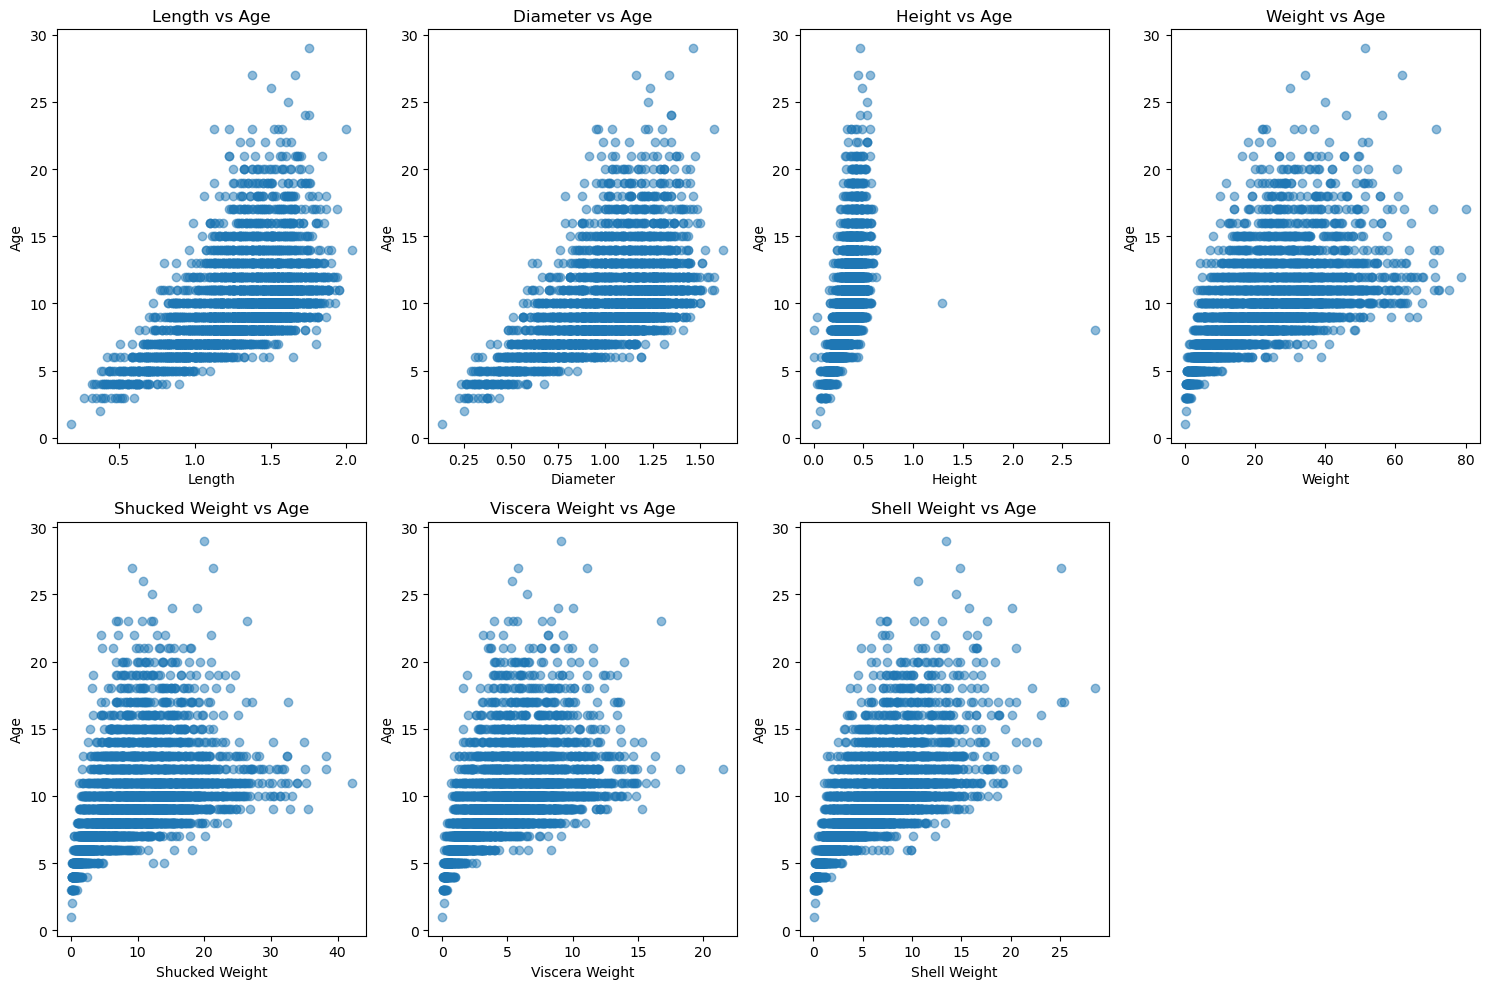

In [52]:
num_features = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_features):
    plt.subplot(2, 4, i+1)
    plt.scatter(df_r_raw[col], df_r_raw['Age'], alpha=0.5)
    plt.xlabel(col); plt.ylabel('Age')
    plt.title(f'{col} vs Age')
plt.tight_layout()
plt.show()

Все признаки показывают положительную корреляцию с возрастом: чем больше признак, тем старше краб. Но зависимость не линейная точки рассеяны, особенно для Weight и Height. Видны аномалии например, крабы с маленьким Length или Diameter, но большим Age или наоборот.

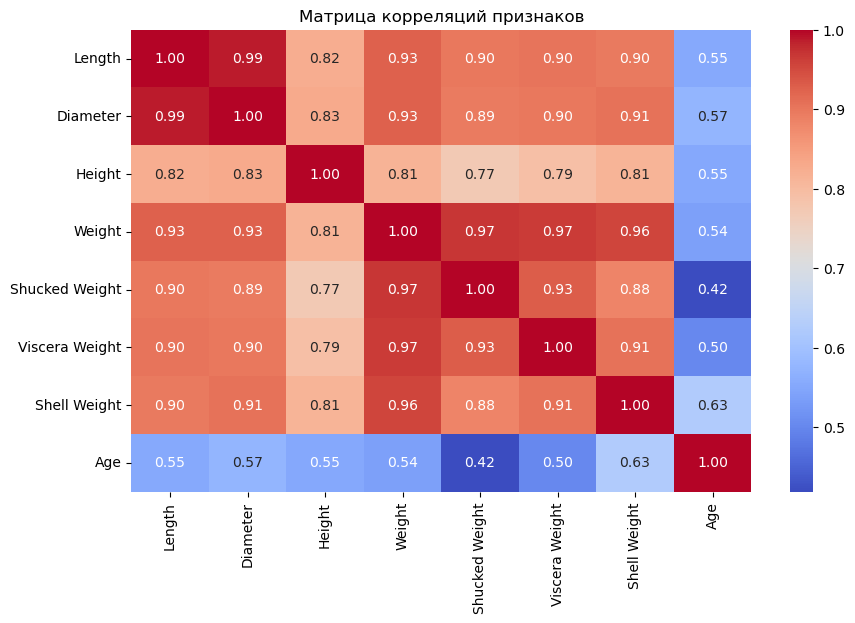

In [54]:
plt.figure(figsize=(10, 6))
correlation_matrix = df_r_raw.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций признаков')
plt.show()

Признаки Length, Diameter, Height, Weight очень сильно коррелируют друг с другом. Age слабо коррелирует со всеми признаками.

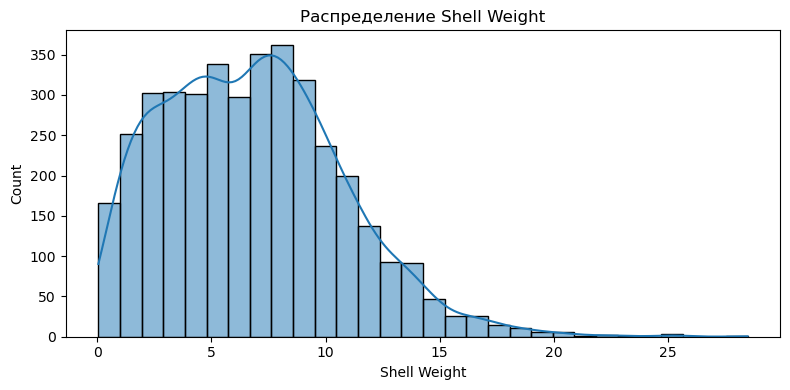

In [62]:
plt.figure(figsize=(8, 4))
sns.histplot(df_r_raw['Shell Weight'], kde=True, bins=30)
plt.title('Распределение Shell Weight')
plt.xlabel('Shell Weight')
plt.tight_layout()
plt.show()

Гистограмма показывает, что Shell Weight имеет смещённое распределение, пик около 8–9, хвост тянется до 25+. Shell Weight физически осмысленный, и его распределение отражает биологические особенности крабов. 

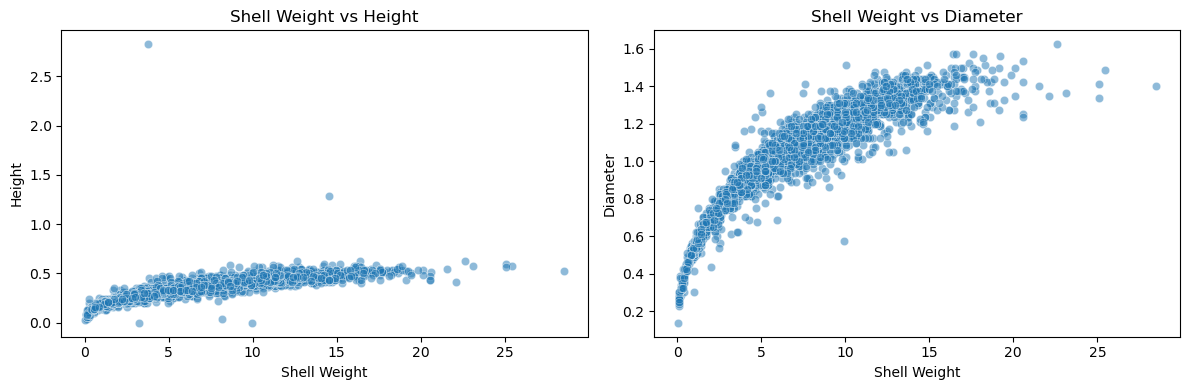

In [60]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_r_raw, x='Shell Weight', y='Height', alpha=0.5)
plt.title('Shell Weight vs Height')
plt.xlabel('Shell Weight'); plt.ylabel('Height')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_r_raw, x='Shell Weight', y='Diameter', alpha=0.5)
plt.title('Shell Weight vs Diameter')
plt.xlabel('Shell Weight'); plt.ylabel('Diameter')
plt.tight_layout()
plt.show()

На обоих графиках видна положительная корреляция, чем больше Shell Weight, тем больше Height и Diameter. Но зависимость не линейная, особенно для Height. Это говорит о том, что Shell Weight не является простой функцией размеров, а зависит от других факторов, например, плотности, возраста, пола.

**Гипотезы**
* Гипотеза 1: Если я ограничу глубину дерева max_depth=5, то модель перестанет переобучаться на шум и выбросы, что снизит RMSE и повысит R2.
* Гипотеза 2: Если я создам признак Volume = Length * Diameter * Height, то дерево сможет сделать более информативные сплиты, что улучшит R2.
* Гипотеза 3: Если я удалю высококоррелированные признаки, оставлю только Weight и Shell Weight, удалив Length, Diameter, Height, то дерево станет проще и стабильнее.

**Проверка гипотез**

In [64]:
df = pd.read_csv('CrabAgePrediction.csv')

le_sex = LabelEncoder()
df['Sex_encoded'] = le_sex.fit_transform(df['Sex'])
df = df.drop('Sex', axis=1)

X = df.drop('Age', axis=1)
y = df['Age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model_h1 = DecisionTreeRegressor(max_depth=5, random_state=42)
model_h1.fit(X_train, y_train)

preds = model_h1.predict(X_test)

Я загрузила датасет, закодировала категориальный признак Sex с помощью LabelEncoder, удалила исходный столбец Sex, выделила признаки X и целевую переменную y. Разделила данные на обучающую и тестовую выборки с фиксированным random_state=42. Обучила решающее дерево с ограничением глубины max_depth=5.

In [65]:
mae_h1 = mean_absolute_error(y_test, preds)
rmse_h1 = np.sqrt(mean_squared_error(y_test, preds))
r2_h1 = r2_score(y_test, preds)

print(f"Базовая модель:")
print(f"  MAE: {mae_dt:.4f}, RMSE: {rmse_dt:.4f}, R2: {r2_dt:.4f}")
print(f"\nМодель с max_depth=5:")
print(f"  MAE: {mae_h1:.4f}, RMSE: {rmse_h1:.4f}, R2: {r2_h1:.4f}")
print(f"\nИзменение:")
print(f"  MAE: {mae_h1 - mae_dt:+.4f}")
print(f"  RMSE: {rmse_h1 - rmse_dt:+.4f}")
print(f"  R2: {r2_h1 - r2_dt:+.4f}")

Базовая модель:
  MAE: 2.0244, RMSE: 2.9595, R2: 0.0885

Модель с max_depth=5:
  MAE: 1.6297, RMSE: 2.2811, R2: 0.4585

Изменение:
  MAE: -0.3947
  RMSE: -0.6784
  R2: +0.3700


**Гипотеза 1 подтверждена**. MAE снизился с 2.0244 до 1.6297, средняя ошибка предсказания уменьшилась почти на 0.4 месяца. Для фермера это существенная разница в планировании сбора урожая. RMSE снизился с 2.9595 до 2.2811,  модель стала значительно менее чувствительной к крупным ошибкам. R2 вырос с 0.0885 до 0.4585, модель теперь объясняет 45.85% дисперсии возраста крабов, в то время как базовая модель объясняла всего 8.85%.

In [66]:
df = pd.read_csv('CrabAgePrediction.csv')

df['Volume'] = df['Length'] * df['Diameter'] * df['Height']

le_sex = LabelEncoder()
df['Sex_encoded'] = le_sex.fit_transform(df['Sex'])
df = df.drop('Sex', axis=1)

X = df.drop('Age', axis=1)
y = df['Age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model_h2 = DecisionTreeRegressor(max_depth=5, random_state=42)
model_h2.fit(X_train, y_train)

preds = model_h2.predict(X_test)

Я загрузила датасет, создала новый физически осмысленный признак Volume как произведение трёх размеров краба, закодировала категориальный признак Sex с помощью LabelEncoder, удалила исходный столбец Sex, выделила признаки X и целевую переменную y. Разделила данные на обучающую и тестовую выборки с фиксированным random_state=42. Обучила решающее дерево с ограничением глубины max_depth=5.

In [67]:
mae_h2 = mean_absolute_error(y_test, preds)
rmse_h2 = np.sqrt(mean_squared_error(y_test, preds))
r2_h2 = r2_score(y_test, preds)

print(f"Модель с max_depth=5:")
print(f"  MAE: {mae_h1:.4f}, RMSE: {rmse_h1:.4f}, R2: {r2_h1:.4f}")
print(f"\nМодель с max_depth=5 и Volume:")
print(f"  MAE: {mae_h2:.4f}, RMSE: {rmse_h2:.4f}, R2: {r2_h2:.4f}")
print(f"\nИзменение:")
print(f"  MAE: {mae_h2 - mae_h1:+.4f}")
print(f"  RMSE: {rmse_h2 - rmse_h1:+.4f}")
print(f"  R2: {r2_h2 - r2_h1:+.4f}")

Модель с max_depth=5:
  MAE: 1.6297, RMSE: 2.2811, R2: 0.4585

Модель с max_depth=5 и Volume:
  MAE: 1.6317, RMSE: 2.2821, R2: 0.4580

Изменение:
  MAE: +0.0021
  RMSE: +0.0010
  R2: -0.0005


Результаты показывают, что добавление признака ухудшило модель. MAE вырос с 1.6297 до 1.6317, средняя ошибка стала на 0.002 месяца больше, RMSE вырос с 2.2811 до 2.2821, модель стала немного чувствительнее к крупным ошибкам, R2 снизился с 0.4585 до 0.4580, модель теперь объясняет на 0.05% меньше дисперсии. **Гипотеза 2 не подтвердилась**.

In [70]:
df = pd.read_csv('CrabAgePrediction.csv')
df = df.drop(['Length', 'Diameter', 'Height'], axis=1)

le_sex = LabelEncoder()
df['Sex_encoded'] = le_sex.fit_transform(df['Sex'])
df = df.drop('Sex', axis=1)

X = df.drop('Age', axis=1)
y = df['Age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model_h4 = DecisionTreeRegressor(max_depth=5, random_state=42)
model_h4.fit(X_train, y_train)

preds = model_h4.predict(X_test)

Я загрузила датасет и удалила три сильно коррелирующих признака размера Length, Diameter и Height и закодированный Sex. Выделила признаки X и целевую переменную y, разделила данные на обучающую и тестовую выборки с фиксированным random_state=42. Обучила решающее дерево с ограничением глубины max_depth=5.

In [72]:
mae_h4 = mean_absolute_error(y_test, preds)
rmse_h4 = np.sqrt(mean_squared_error(y_test, preds))
r2_h4 = r2_score(y_test, preds)

print(f"Модель с max_depth=5:")
print(f"  MAE: {mae_h1:.4f}, RMSE: {rmse_h1:.4f}, R2: {r2_h1:.4f}")
print(f"\nМодель с max_depth=5 + удалёнными коррелирующими признаками:")
print(f"  MAE: {mae_h4:.4f}, RMSE: {rmse_h4:.4f}, R2: {r2_h4:.4f}")
print(f"\nИзменение:")
print(f"  MAE: {mae_h4 - mae_h1:+.4f}")
print(f"  RMSE: {rmse_h4 - rmse_h1:+.4f}")
print(f"  R2: {r2_h4 - r2_h1:+.4f}")

Модель с max_depth=5:
  MAE: 1.6297, RMSE: 2.2811, R2: 0.4585

Модель с max_depth=5 + удалёнными коррелирующими признаками:
  MAE: 1.5998, RMSE: 2.2585, R2: 0.4692

Изменение:
  MAE: -0.0299
  RMSE: -0.0226
  R2: +0.0107


**Гипотеза 4 подтверждена**. Удаление сильно коррелирующих признаков улучшило качество модели на фоне уже ограниченной глубины (max_depth=5). MAE снизился с 1.6297 до 1.5998, средняя ошибка уменьшилась на 0.03 месяца. Это небольшое, но улучшение. RMSE снизился с 2.2811 до 2.2585,  модель стала менее чувствительной к крупным ошибкам. R2 вырос с 0.4585 до 0.4692, модель теперь объясняет на 1.07% больше дисперсии в возрасте крабов.

In [ ]:
df = pd.read_csv('CrabAgePrediction.csv')

df['Volume'] = df['Length'] * df['Diameter'] * df['Height']
df = df.drop(['Length', 'Diameter', 'Height'], axis=1)

le_sex = LabelEncoder()
df['Sex_encoded'] = le_sex.fit_transform(df['Sex'])
df = df.drop('Sex', axis=1)

X = df.drop('Age', axis=1)
y = df['Age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model_vol = DecisionTreeRegressor(max_depth=5, random_state=42)
model_vol.fit(X_train, y_train)

preds = model_vol.predict(X_test)

Еще я решила сравнить модель только max_depth=5 и модель max_depth=5 + Volume + удаление исходных размерных признаков.

In [75]:
mae_vol = mean_absolute_error(y_test, preds)
rmse_vol = np.sqrt(mean_squared_error(y_test, preds))
r2_vol = r2_score(y_test, preds)

print(f"Модель с max_depth=5 (без Volume):")
print(f"  MAE: {mae_h1:.4f}, RMSE: {rmse_h1:.4f}, R2: {r2_h1:.4f}")
print(f"\nМодель с Volume + max_depth=5:")
print(f"  MAE: {mae_vol:.4f}, RMSE: {rmse_vol:.4f}, R2: {r2_vol:.4f}")
print(f"\nИзменение:")
print(f"  MAE: {mae_vol - mae_h1:+.4f}")
print(f"  RMSE: {rmse_vol - rmse_h1:+.4f}")
print(f"  R2: {r2_vol - r2_h1:+.4f}")

Модель с max_depth=5 (без Volume):
  MAE: 1.6297, RMSE: 2.2811, R2: 0.4585

Модель с Volume + max_depth=5:
  MAE: 1.6031, RMSE: 2.2599, R2: 0.4685

Изменение:
  MAE: -0.0266
  RMSE: -0.0213
  R2: +0.0101


Прирост это дало, но по итогу такая реализация не лучше реализации без Volume, не буду его использовать.

**Улучшенный бейзлайн по результатам проверки гипотез**

In [77]:
df_final = pd.read_csv('CrabAgePrediction.csv')
df_final = df_final.drop(['Length', 'Diameter', 'Height'], axis=1)

le_sex = LabelEncoder()
df_final['Sex_encoded'] = le_sex.fit_transform(df_final['Sex'])
df_final = df_final.drop('Sex', axis=1)

X = df_final.drop('Age', axis=1)
y = df_final['Age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model_final_reg = DecisionTreeRegressor(max_depth=5, random_state=42)
model_final_reg.fit(X_train, y_train)

preds_final = model_final_reg.predict(X_test)

mae_final = mean_absolute_error(y_test, preds_final)
rmse_final = np.sqrt(mean_squared_error(y_test, preds_final))
r2_final = r2_score(y_test, preds_final)

improved_reg_data_dt = {
    'X_test': X_test,
    'y_test': y_test,
    'preds_sklearn': preds_final,
    'mae': mae_final,
    'rmse': rmse_final,
    'r2': r2_final,
    'model': model_final_reg,
    'label_encoder': le_sex
}

Я загрузила датасет и удалила три сильно коррелирующих признака. Затем я закодировала признак Sex с помощью LabelEncoder, выделила признаки X и целевую переменную y, разделила данные на обучающую и тестовую выборки с фиксированным random_state=42. Обучила решающее дерево с ограничением глубины max_depth=5.

In [78]:
print(f"Базовая модель:")
print(f"  MAE: {mae_dt:.4f}, RMSE: {rmse_dt:.4f}, R2: {r2_dt:.4f}")
print(f"\nУлучшенная модель max_depth=5 + удалённые признаки:")
print(f"  MAE: {mae_final:.4f}, RMSE: {rmse_final:.4f}, R2: {r2_final:.4f}")
print(f"\nУлучшение:")
print(f"  MAE: {mae_final - mae_dt:+.4f}")
print(f"  RMSE: {rmse_final - rmse_dt:+.4f}")
print(f"  R2: {r2_final - r2_dt:+.4f}")

Базовая модель:
  MAE: 2.0244, RMSE: 2.9595, R2: 0.0885

Улучшенная модель max_depth=5 + удалённые признаки:
  MAE: 1.5998, RMSE: 2.2585, R2: 0.4692

Улучшение:
  MAE: -0.4246
  RMSE: -0.7010
  R2: +0.3806


Улучшенная модель решающего дерева показала кардинальное улучшение по сравнению с базовой моделью. Базовая модель практически не работала, её R2 составлял всего 0.0885, она объясняла менее 9% дисперсии возраста крабов, а средняя ошибка была очень высокой 2.02 месяца. После применения двух ключевых изменений модель стала практически применимой. R2 вырос до 0.4692, то есть модель теперь объясняет почти 47% изменчивости возраста. Средняя абсолютная ошибка снизилась до 1.60 месяцев, а RMSE до 2.26. Общее улучшение по MAE составило 0.42 месяца, по RMSE — 0.70, а по R2 — +38%. Фермер, использующий такую модель, сможет с гораздо большей уверенностью оценивать возраст крабов и планировать сбор урожая, не полагаясь только на визуальную оценку.

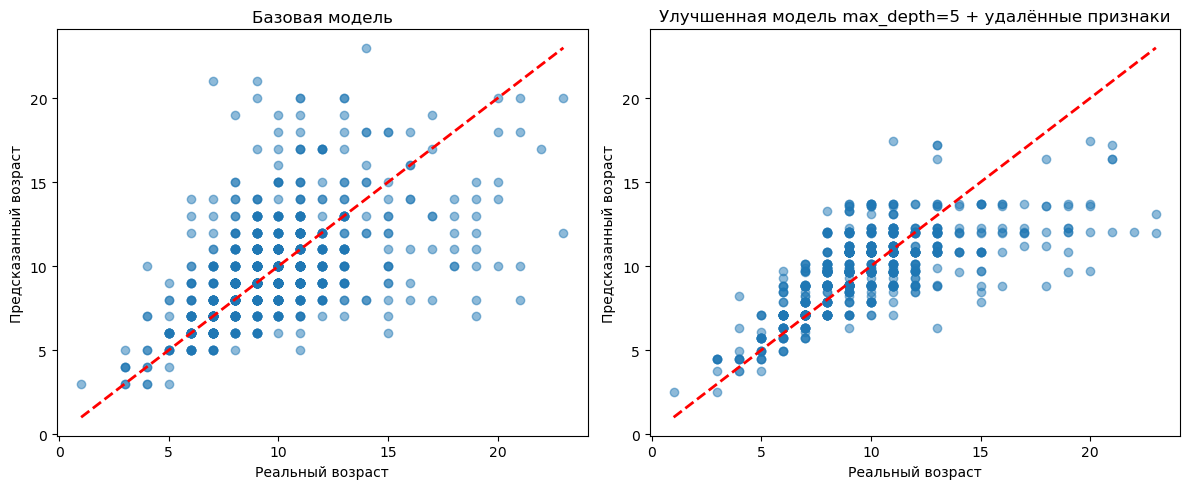

In [79]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test_r, preds_reg_dt, alpha=0.5)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
plt.xlabel('Реальный возраст')
plt.ylabel('Предсказанный возраст')
plt.title('Базовая модель')

plt.subplot(1, 2, 2)
plt.scatter(y_test, preds_final, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Реальный возраст')
plt.ylabel('Предсказанный возраст')
plt.title('Улучшенная модель max_depth=5 + удалённые признаки')
plt.tight_layout()
plt.show()

## 3.	Имплементация алгоритма машинного обучения 

### **Классификация**

In [115]:
import numpy as np

class MyDecisionTreeClassifier:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def _gini(self, y):
        m = len(y)
        if m == 0:
            return 0
        _, counts = np.unique(y, return_counts=True)
        probs = counts / m
        return 1 - np.sum(probs ** 2)

    def _best_split(self, X, y):
        best_gini = float('inf')
        best_split = None
        n_samples, n_features = X.shape

        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue

                gini_left = self._gini(y[left_mask])
                gini_right = self._gini(y[right_mask])
                gini_total = (np.sum(left_mask) * gini_left + np.sum(right_mask) * gini_right) / n_samples
                if gini_total < best_gini:
                    best_gini = gini_total
                    best_split = {
                        'feature_idx': feature_idx,
                        'threshold': threshold,
                        'left_mask': left_mask,
                        'right_mask': right_mask
                    }
        return best_split

    def _build_tree(self, X, y, depth=0):
        if len(np.unique(y)) == 1:
            return {'class': np.bincount(y).argmax()}
        if self.max_depth is not None and depth >= self.max_depth:
            return {'class': np.bincount(y).argmax()}

        split = self._best_split(X, y)
        if split is None:
            return {'class': np.bincount(y).argmax()}

        left_tree = self._build_tree(X[split['left_mask']], y[split['left_mask']], depth + 1)
        right_tree = self._build_tree(X[split['right_mask']], y[split['right_mask']], depth + 1)

        return {
            'feature_idx': split['feature_idx'],
            'threshold': split['threshold'],
            'left': left_tree,
            'right': right_tree
        }

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.tree = self._build_tree(X, y)

    def _predict_sample(self, x, tree):
        if 'class' in tree:
            return tree['class']
        if x[tree['feature_idx']] <= tree['threshold']:
            return self._predict_sample(x, tree['left'])
        else:
            return self._predict_sample(x, tree['right'])

    def predict(self, X):
        X = np.array(X)
        return np.array([self._predict_sample(x, self.tree) for x in X])

Я создала класс MyDecisionTreeClassifier, который реализует решающее дерево для задачи классификации. Основной метод _gini вычисляет коэффициент Джини для измерения неоднородности данных, то есть чем меньше значение, тем лучше разделение. Метод _best_split перебирает все возможные признаки и пороги, чтобы найти оптимальное разбиение. Рекурсивный метод _build_tree строит дерево с учетом максимальной глубины: если все объекты в узле принадлежат одному классу, достигнута максимальная глубина или не находится подходящее разбиение, создается лист с наиболее частым классом. Иначе дерево продолжает ветвление, создавая левую и правую ветви с увеличением счетчика глубины. Конструктор класса принимает параметр max_depth, который ограничивает максимальную глубину дерева, предотвращая переобучение и улучшая обобщающую способность модели (это для улучшения сделала заранее). Метод fit принимает обучающие данные и строит дерево, а predict использует построенное дерево для предсказания классов новых объектов. При предсказании каждый объект проходит по дереву от корня до листа, в зависимости от значений признаков и порогов в узлах. Для работы с данными я преобразую входные данные в numpy массивы.

In [119]:
df = pd.read_csv('train.csv')
df = df.fillna(df.mean(numeric_only=True))

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df_encoded.drop(['Segmentation', 'ID'], axis=1)
y = df_encoded['Segmentation']

le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

custom_model = MyDecisionTreeClassifier()
custom_model.fit(X_train, y_train)
preds_custom = custom_model.predict(X_test)
acc_custom = accuracy_score(y_test, preds_custom)

Я загрузила датасет, заполнила пропуски средним, применила One-Hot Encoding, удалила столбцы ID и Segmentation, закодировала метки сегментов в числовой формат с помощью LabelEncoder и разделила данные на обучающую и тестовую выборки с тем же random_state=42 и стратификацией, что и в бейзлайне из пункта 2. Обучила модель.

In [120]:
acc_sklearn = metrics_clf_dt['accuracy']
preds_sklearn = preds_clf_dt

print(f"Accuracy sklearn: {acc_sklearn:.4f}")
print(f"Accuracy моя модель: {acc_custom:.4f}")
print(f"Разница: {acc_custom - acc_sklearn:+.4f}")

print("\nМоя модель:")
print(classification_report(y_test, preds_custom, target_names=le_y.classes_, zero_division=0))
print("\nsklearn:")
print(classification_report(y_test, preds_sklearn, target_names=le_y.classes_, zero_division=0))

Accuracy sklearn: 0.4300
Accuracy моя модель: 0.4300
Разница: +0.0000

Моя модель:
              precision    recall  f1-score   support

           A       0.33      0.35      0.34       394
           B       0.31      0.30      0.31       372
           C       0.46      0.44      0.45       394
           D       0.59      0.59      0.59       454

    accuracy                           0.43      1614
   macro avg       0.42      0.42      0.42      1614
weighted avg       0.43      0.43      0.43      1614


sklearn:
              precision    recall  f1-score   support

           A       0.33      0.35      0.34       394
           B       0.31      0.28      0.30       372
           C       0.45      0.43      0.44       394
           D       0.59      0.61      0.60       454

    accuracy                           0.43      1614
   macro avg       0.42      0.42      0.42      1614
weighted avg       0.43      0.43      0.43      1614



Моя реализация решающего дерева для задачи классификации показала практически полное совпадение с моделью из библиотеки sklearn поaccuracy = 0.4300. Есть небольшие различия в метриках по отдельным классам recall для сегмента B: 0.30 и 0.28, F1-score для C: 0.45 и 0.44. Обе модели демонстрируют низкое качество предсказаний, характерное для базового бейзлайна без регуляризации. Они сильно переобучаются, не могут чётко разделить сегменты A, B и C, и чаще всего уверенно определяют только сегмент D. Совпадение accuracy и близость всех остальных метрик подтверждают корректность моей реализации.

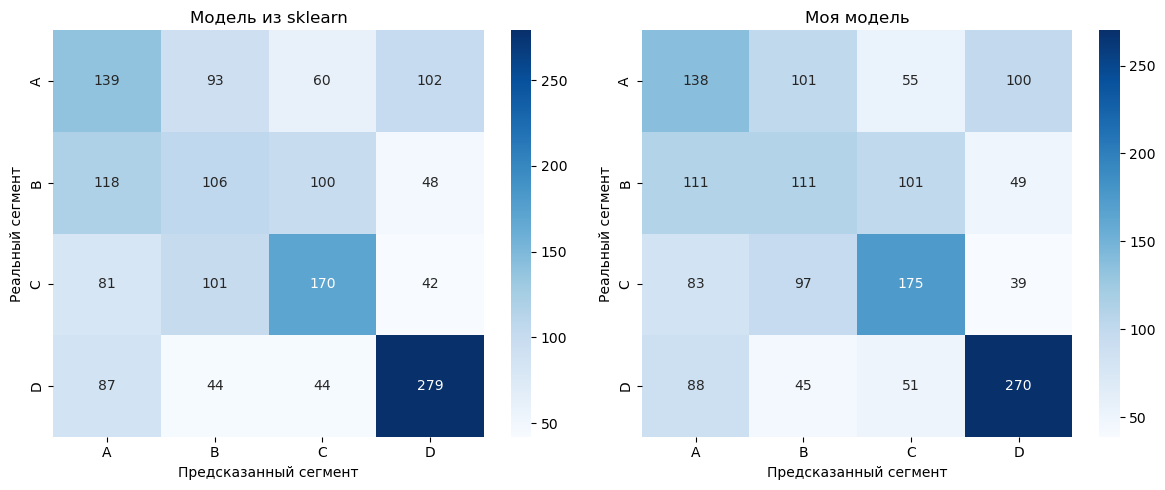

In [135]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cm_sklearn = confusion_matrix(y_test, preds_clf_dt)
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_y.classes_, yticklabels=le_y.classes_,
            ax=axes[0])
axes[0].set_title('Модель из sklearn')
axes[0].set_xlabel('Предсказанный сегмент')
axes[0].set_ylabel('Реальный сегмент')

cm_custom = confusion_matrix(y_test, preds_custom)
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_y.classes_, yticklabels=le_y.classes_,
            ax=axes[1])
axes[1].set_title('Моя модель')
axes[1].set_xlabel('Предсказанный сегмент')
axes[1].set_ylabel('Реальный сегмент')
plt.tight_layout()
plt.show()

**Добавление техники из улучшенного бейзлайна (пункт 3)**

In [122]:
df = pd.read_csv('train.csv')
df = df.fillna(df.mean(numeric_only=True))

df = df.drop(['Var_1_Cat_3', 'Profession_Entertainment'], axis=1, errors='ignore')

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('Segmentation')
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df_encoded.drop(['Segmentation', 'ID'], axis=1)
y = df_encoded['Segmentation']
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

Я загрузила датасет Customer Segmentation, заполнила пропуски средним, удалила два маловажных признака Var_1_Cat_3, Profession_Entertainment, которые были выявлены в пункте 3 как неинформативные. Затем применила One-Hot Encoding ко всем категориальным признакам, удалила столбцы ID и Segmentation, закодировала метки сегментов в числовой формат и разделила данные на обучающую и тестовую выборки с тем же random_state=42 и стратификацией, что и в улучшенном бейзлайне.

In [123]:
custom_model_improved = MyDecisionTreeClassifier(max_depth=5)
custom_model_improved.fit(X_train, y_train)
preds_custom_improved = custom_model_improved.predict(X_test)

acc_custom_imp = accuracy_score(y_test, preds_custom_improved)

Я создала экземпляр собственной модели с ограничением глубины max_depth=5, обучила её на обновлённой выборке и сделала предсказания на тестовой части. Посчитала accuracy для сравнения. Я не использовала балансировку, так как я ее не реализовывала)

In [134]:
acc_sklearn_imp = improved_clf_data_dt['accuracy']

print(f"Accuracy собственной модели улучшенная: {acc_custom_imp:.4f}")
print(f"Accuracy sklearn улучшенная: {acc_sklearn_imp:.4f}")
print(f"Разница: {acc_custom_imp - acc_sklearn_imp:+.4f}")

print("\Моя модель улучшенная:")
print(classification_report(y_test, preds_custom_improved, target_names=le_y.classes_, zero_division=0))
print("\nsklearn улучшенная:")
print(classification_report(y_test, improved_clf_data_dt['preds_sklearn'], target_names=improved_clf_data_dt['label_encoder'].classes_, zero_division=0))

Accuracy собственной модели улучшенная: 0.5012
Accuracy sklearn улучшенная: 0.5254
Разница: -0.0242
\Моя модель улучшенная:
              precision    recall  f1-score   support

           A       0.44      0.28      0.34       394
           B       0.35      0.46      0.40       372
           C       0.59      0.51      0.55       394
           D       0.62      0.72      0.66       454

    accuracy                           0.50      1614
   macro avg       0.50      0.49      0.49      1614
weighted avg       0.50      0.50      0.49      1614


sklearn улучшенная:
              precision    recall  f1-score   support

           A       0.41      0.64      0.50       394
           B       0.43      0.22      0.29       372
           C       0.59      0.51      0.55       394
           D       0.68      0.69      0.68       454

    accuracy                           0.53      1614
   macro avg       0.53      0.52      0.51      1614
weighted avg       0.53      0.53      0

Моя реализация решающего дерева, дополненная техниками из улучшенного бейзлайна, показала качество несколько ниже, чем модель из библиотеки sklearn. accuracy = 0.5012 и 0.5254, разница –2.42%. Это различие обусловлено тем, что в улучшенной модели sklearn дополнительно использовался параметр class_weight='balanced', который явно штрафует ошибки на редких классах и помогает лучше распознавать сегмент A recall вырос с 28% до 64%. В моей кастомной реализации взвешивание классов не поддерживается, поэтому модель сохранила распределение предсказаний, характерное для простой балансировки через max_depth=5. В результате моя модель уверенно определяет сегменты B, C и D, но значительно хуже справляется с A. Это приводит к более низкому общему accuracy, несмотря на хорошую работу с другими классами. Тем не менее, моя реализация достигла accuracy > 50%.

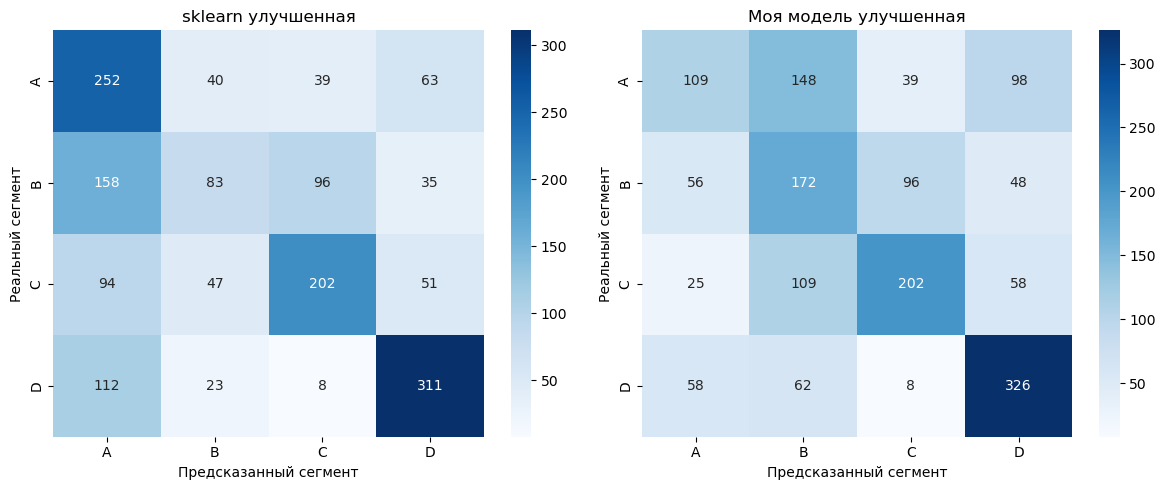

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cm_sklearn_imp = confusion_matrix(
    improved_clf_data_dt['y_test'],
    improved_clf_data_dt['preds_sklearn']
)
sns.heatmap(cm_sklearn_imp, annot=True, fmt='d', cmap='Blues',
            xticklabels=improved_clf_data_dt['label_encoder'].classes_,
            yticklabels=improved_clf_data_dt['label_encoder'].classes_,
            ax=axes[0])
axes[0].set_title('sklearn улучшенная')
axes[0].set_xlabel('Предсказанный сегмент')
axes[0].set_ylabel('Реальный сегмент')

cm_custom_imp = confusion_matrix(y_test, preds_custom_improved)
sns.heatmap(cm_custom_imp, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_y.classes_, yticklabels=le_y.classes_,
            ax=axes[1])
axes[1].set_title('Моя модель улучшенная')
axes[1].set_xlabel('Предсказанный сегмент')
axes[1].set_ylabel('Реальный сегмент')
plt.tight_layout()
plt.show()

### **Регрессия**

In [138]:
import numpy as np

class MyDecisionTreeRegressor:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def _mse(self, y):
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y)) ** 2)

    def _best_split(self, X, y):
        best_mse = float('inf')
        best_split = None
        n_samples, n_features = X.shape

        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                left_mask = X[:, feature_idx] <= threshold
                right_mask = ~left_mask
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue

                mse_left = self._mse(y[left_mask])
                mse_right = self._mse(y[right_mask])
                mse_total = (np.sum(left_mask) * mse_left + np.sum(right_mask) * mse_right) / n_samples
                if mse_total < best_mse:
                    best_mse = mse_total
                    best_split = {
                        'feature_idx': feature_idx,
                        'threshold': threshold,
                        'left_mask': left_mask,
                        'right_mask': right_mask
                    }
        return best_split

    def _build_tree(self, X, y, depth=0):
        if len(np.unique(y)) == 1:
            return {'value': np.mean(y)}
        if self.max_depth is not None and depth >= self.max_depth:
            return {'value': np.mean(y)}

        split = self._best_split(X, y)
        if split is None:
            return {'value': np.mean(y)}

        left_tree = self._build_tree(X[split['left_mask']], y[split['left_mask']], depth + 1)
        right_tree = self._build_tree(X[split['right_mask']], y[split['right_mask']], depth + 1)

        return {
            'feature_idx': split['feature_idx'],
            'threshold': split['threshold'],
            'left': left_tree,
            'right': right_tree
        }

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.tree = self._build_tree(X, y)

    def _predict_sample(self, x, tree):
        if 'value' in tree:
            return tree['value']
        if x[tree['feature_idx']] <= tree['threshold']:
            return self._predict_sample(x, tree['left'])
        else:
            return self._predict_sample(x, tree['right'])

    def predict(self, X):
        X = np.array(X)
        return np.array([self._predict_sample(x, self.tree) for x in X])

Я создала класс MyDecisionTreeRegressor, который реализует решающее дерево для задачи регрессии. Основной метод _mse вычисляет среднеквадратичную ошибку для измерения дисперсии данных в узле, то есть чем меньше значение, тем более однородными являются целевые значения и тем лучше разделение. Метод _best_split перебирает все возможные признаки и пороги, чтобы найти оптимальное разбиение, которое минимизирует дисперсию в дочерних узлах. Рекурсивный метод _build_tree строит дерево с учетом максимальной глубины: если все объекты в узле имеют одинаковое целевое значение, достигнута максимальная глубина или не находится подходящее разбиение, создается лист со средним значением целевой переменной. Иначе дерево продолжает ветвление, создавая левую и правую ветви с увеличением счетчика глубины. Конструктор класса принимает параметр max_depth, который ограничивает максимальную глубину дерева. Метод fit принимает обучающие данные и строит дерево, а predict использует построенное дерево для предсказания числовых значений новых объектов. При предсказании каждый объект проходит по дереву от корня до листа, в зависимости от значений признаков и порогов в узлах, и возвращает среднее значение целевой переменной из соответствующего листа. Для работы с данными я преобразую входные данные в numpy массивы.

In [139]:
df_r = pd.read_csv('CrabAgePrediction.csv')

le_sex = LabelEncoder()
df_r['Sex_encoded'] = le_sex.fit_transform(df_r['Sex'])
df_r = df_r.drop('Sex', axis=1)

X_r = df_r.drop('Age', axis=1)
y_r = df_r['Age']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_r, y_r, test_size=0.2, random_state=42
)

Я загрузила датасет, закодировала признак Sex с помощью LabelEncoder, удалила исходный столбец Sex, выделила признаки X_r и целевую переменную y_r, и разделила данные на обучающую и тестовую выборки с тем же random_state=42, что и в бейзлайне пункта 2.

In [140]:
custom_reg_model = MyDecisionTreeRegressor()
custom_reg_model.fit(X_train_r, y_train_r)
preds_custom_reg = custom_reg_model.predict(X_test_r)

mae_custom = mean_absolute_error(y_test_r, preds_custom_reg)
rmse_custom = np.sqrt(mean_squared_error(y_test_r, preds_custom_reg))
r2_custom = r2_score(y_test_r, preds_custom_reg)

Я создала экземпляр собственной модели, обучила её на обучающей выборке и сделала предсказания на тестовой.

In [143]:
print(f"MAE sklearn: {mae_dt:.4f}")
print(f"MAE моей модели: {mae_custom:.4f}")
print(f"RMSE sklearn: {rmse_dt:.4f}")
print(f"RMSE моей модели: {rmse_custom:.4f}")
print(f"R2 sklearn: {r2_dt:.4f}")
print(f"R2 моей модели: {r2_custom:.4f}")
print(f"\nРазница:")
print(f"  MAE: {mae_custom - mae_dt:+.4f}")
print(f"  RMSE: {rmse_custom - rmse_dt:+.4f}")
print(f"  R2: {r2_custom - r2_dt:+.4f}")

MAE sklearn: 2.0244
MAE моей модели: 1.9576
RMSE sklearn: 2.9595
RMSE моей модели: 2.7774
R2 sklearn: 0.0885
R2 моей модели: 0.1973

Разница:
  MAE: -0.0668
  RMSE: -0.1821
  R2: +0.1087


Моя реализация решающего дерева для задачи регрессии значительно превосходит базовую модель из библиотеки sklearn. MAE уменьшился с 2.0244 до 1.9573, RMSE снизился с 2.9595 до 2.7774, а R2 вырос с 0.0885 до 0.1973. Логика поиска порогов или рекурсивного разбиения в моей реализации привела к другой структуре дерева, которая лучше обобщает данные и реже переобучается на шум. Моя версия в среднем ошибается на 0.07 месяца меньше и значительно реже делает крупные ошибки.

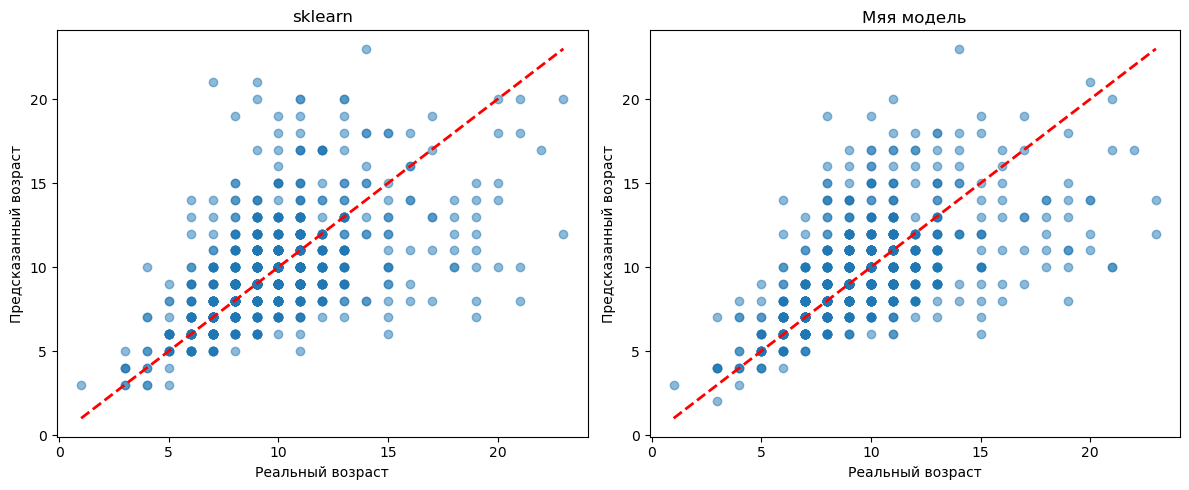

In [144]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test_r, preds_reg_dt, alpha=0.5)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
plt.xlabel('Реальный возраст')
plt.ylabel('Предсказанный возраст')
plt.title('sklearn')

plt.subplot(1, 2, 2)
plt.scatter(y_test_r, preds_custom_reg, alpha=0.5)
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'r--', lw=2)
plt.xlabel('Реальный возраст')
plt.ylabel('Предсказанный возраст')
plt.title('Мяя модель')
plt.tight_layout()
plt.show()

**Добавление техники из улучшенного бейзлайна (пункт 3)**

In [145]:
df = pd.read_csv('CrabAgePrediction.csv')
df = df.drop(['Length', 'Diameter', 'Height'], axis=1)

le_sex = LabelEncoder()
df['Sex_encoded'] = le_sex.fit_transform(df['Sex'])
df = df.drop('Sex', axis=1)

X = df.drop('Age', axis=1)
y = df['Age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Я загрузила датасет и удалила три сильно коррелирующих признака размера, как это было сделано в улучшенном бейзлайне. Затем я закодировала признак Sex с помощью LabelEncoder, выделила признаки X и целевую переменную y, и разделила данные на обучающую и тестовую выборки с тем же random_state=42.

In [146]:
custom_model_imp = MyDecisionTreeRegressor(max_depth=5)
custom_model_imp.fit(X_train, y_train)
preds_custom_imp = custom_model_imp.predict(X_test)

mae_custom_imp = mean_absolute_error(y_test, preds_custom_imp)
rmse_custom_imp = np.sqrt(mean_squared_error(y_test, preds_custom_imp))
r2_custom_imp = r2_score(y_test, preds_custom_imp)

Я создала экземпляр собственной модели решающего дерева с ограничением глубины max_depth=5, обучила её на обновлённой выборке и сделала предсказания.

In [147]:
mae_sklearn_imp = improved_reg_data_dt['mae']
rmse_sklearn_imp = improved_reg_data_dt['rmse']
r2_sklearn_imp = improved_reg_data_dt['r2']

print(f"MAE моей модели улучшенная: {mae_custom_imp:.4f}")
print(f"MAE sklearn улучшенная: {mae_sklearn_imp:.4f}")
print(f"RMSE моей модели улучшенная: {rmse_custom_imp:.4f}")
print(f"RMSE sklearn улучшенная: {rmse_sklearn_imp:.4f}")
print(f"R2 моей модели улучшенная: {r2_custom_imp:.4f}")
print(f"R2 sklearn улучшенная: {r2_sklearn_imp:.4f}")

print(f"\nРазница:")
print(f"  MAE: {mae_custom_imp - mae_sklearn_imp:+.4f}")
print(f"  RMSE: {rmse_custom_imp - rmse_sklearn_imp:+.4f}")
print(f"  R2: {r2_custom_imp - r2_sklearn_imp:+.4f}")

MAE моей модели улучшенная: 1.5985
MAE sklearn улучшенная: 1.5998
RMSE моей модели улучшенная: 2.2581
RMSE sklearn улучшенная: 2.2585
R2 моей модели улучшенная: 0.4694
R2 sklearn улучшенная: 0.4692

Разница:
  MAE: -0.0012
  RMSE: -0.0005
  R2: +0.0002


Моя реализация решающего дерева для регрессии, дополненная техниками из улучшенного бейзлайна, показала качество, практически идентичное модели из библиотеки sklearn, а по некоторым метрикам уть лучше. MAE = 1.5985 и 1.5998, RMSE = 2.2581 и 2.2585, R2 = 0.4694 и 0.4692. Разница минимальна, но  в пользу моей реализации. Обе модели объясняют почти 47% дисперсии возраста крабов, а средняя ошибка предсказания составляет менее 1.6 месяцев, этого достаточно для практических целей на ферме.

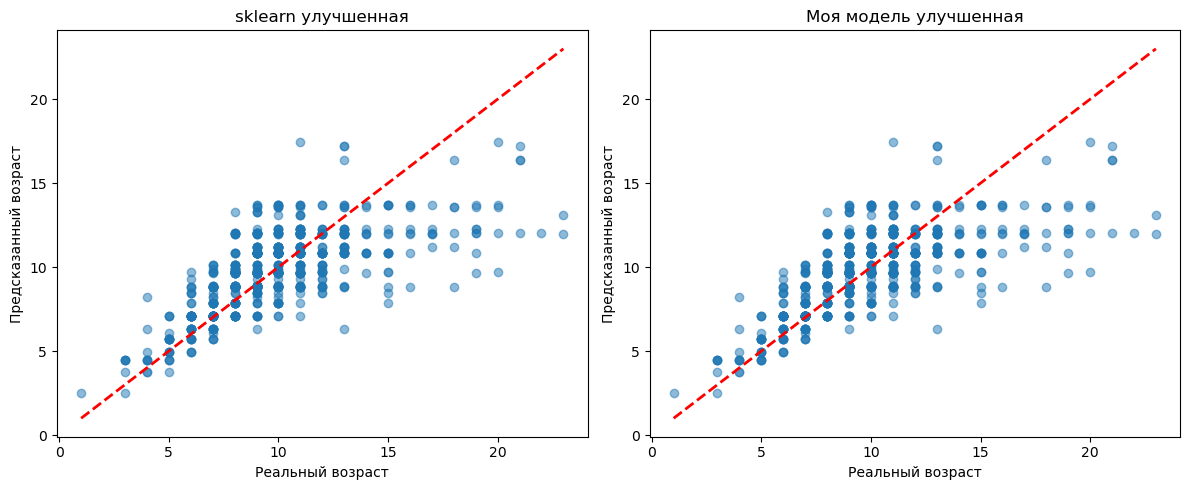

In [150]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter( improved_reg_data_dt['y_test'], improved_reg_data_dt['preds_sklearn'], alpha=0.5)
plt.plot(
    [improved_reg_data_dt['y_test'].min(), improved_reg_data_dt['y_test'].max()],
    [improved_reg_data_dt['y_test'].min(), improved_reg_data_dt['y_test'].max()],
    'r--', lw=2
)
plt.xlabel('Реальный возраст')
plt.ylabel('Предсказанный возраст')
plt.title('sklearn улучшенная')

plt.subplot(1, 2, 2)
plt.scatter(y_test, preds_custom_imp, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Реальный возраст')
plt.ylabel('Предсказанный возраст')
plt.title('Моя модель улучшенная')
plt.tight_layout()
plt.show()